In [1]:
import pandas as pd
import re
import requests
import shutil
import time
import geocoder
import random
import networkx as nx
import itertools
from networkx.algorithms import community
from typing import List, Dict, Tuple, Optional
from tqdm import tqdm
from pathlib import Path
from py7zr import unpack_7zarchive

In [3]:
MAIN_URL = "https://archive.org/download/stackexchange"
DATA_DIR = Path("../data")

In [129]:

try:
    shutil.register_unpack_format('7zip', ['.7z'], unpack_7zarchive)
except shutil.RegistryError:
    pass
def download_stackexchange(stack: str) -> None:
    url = f"{MAIN_URL}/{stack}.stackexchange.com.7z"
    # if file exists then skip
    if (DATA_DIR / f"{stack}.stackexchange.com.7z").exists():
        return None
    print(f"Downloading {stack} from {url}")
    data = requests.get(url)
    # check if data is valid
    with open(DATA_DIR / f"{stack}.stackexchange.com.7z", "wb") as f:
        f.write(data.content)
    
def unpack_stackexchange(stack: str) -> None:
    save_dir = DATA_DIR / stack
    if not save_dir.exists():
        save_dir.mkdir()
    if next(save_dir.iterdir(), None):
        return None
    filename = DATA_DIR / f"{stack}.stackexchange.com.7z"
    if not filename.exists():
        raise ValueError(f"File not found: {filename}")
    print(f"Unpacking {filename}")
    shutil.unpack_archive(filename, DATA_DIR / stack)

def download_and_unpack(stack: str) -> None:
    download_stackexchange(stack)
    unpack_stackexchange(stack)

def IoU(set1: set, set2: set) -> float:
    return len(set1.intersection(set2)) / len(set1.union(set2))

In [12]:
unpack_stackexchange("politics")

Unpacking ..\data\politics.stackexchange.com.7z


In [42]:
def read_user_data(user_xml: Path, cols=["Id", "Reputation", "Location"]) -> pd.DataFrame:
    """Reads the user data from the XML file."""
    # read the xml file
    df = pd.read_xml(user_xml, "row")
    return df[cols]

userdf = read_user_data(DATA_DIR / "politics" / "Users.xml")

C:\Users\jhr\AppData\Local\Temp\ipykernel_584\1218458623.py:4: FutureWarning: In a future version of pandas all arguments of read_xml except for the argument 'path_or_buffer' will be keyword-only.
  df = pd.read_xml(user_xml, "row")


,Id,Reputation,Location
0,-1,1,on the server farm
1,1,101,"Corvallis, OR"
2,2,100,"New York, NY"
3,3,101,"New York, NY, United States"
4,4,1,None
...,...,...,...
36322,44448,1,None
36323,44449,1,None
36324,44450,131,None
36325,44451,101,"San Francisco, CA, USA"


In [43]:
userdf["meta_location"] = userdf["Location"].str.split(",").str[-1].str.strip()
userdf = userdf.assign(loc_id = userdf.groupby("meta_location").ngroup().astype("category"))

C:\Users\jhr\AppData\Local\Temp\ipykernel_584\2243356784.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  userdf["meta_location"] = userdf["Location"].str.split(",").str[-1].str.strip()


In [47]:
location_counts = userdf["meta_location"].value_counts()
common_location_filter = location_counts[location_counts > 1].index
locdf = userdf.loc[userdf["meta_location"].isin(common_location_filter), ["loc_id", "meta_location"]].drop_duplicates()
locdf


,loc_id,meta_location
0,1532.0,on the server farm
1,912.0,OR
2,833.0,NY
3,1335.0,United States
5,428.0,FL
...,...,...
32125,808.0,Multan
32891,1023.0,Quận 4
33592,1169.0,Spamalot
34705,902.0,Novosibirsk


In [49]:


session = requests.Session()

for i, row in tqdm(locdf.iterrows()):
    loc = row["meta_location"]
    if not loc:
        continue
    try:
        g = geocoder.osm(loc, session=session)
    except ValueError:
        locdf.loc[i, "country"] = None
        continue
    if g.ok:
        locdf.loc[i, "country"] = g.country
    else:
        print(f"Failed to get coordinates for {loc} with error {g.status}")
        locdf.loc[i, "country"] = None
    time.sleep(1)


0it [00:00, ?it/s]

Getting coordinates for on the server farm
Failed to get coordinates for on the server farm with error ERROR - No results found


1it [00:04,  4.80s/it]

Getting coordinates for OR


2it [00:05,  2.63s/it]

Getting coordinates for NY


3it [00:06,  1.91s/it]

Getting coordinates for United States


4it [00:08,  1.58s/it]

Getting coordinates for FL


5it [00:09,  1.41s/it]

Getting coordinates for Indiana


6it [00:10,  1.30s/it]

Getting coordinates for MO


7it [00:11,  1.24s/it]

Getting coordinates for USA


8it [00:12,  1.20s/it]

Getting coordinates for United Kingdom


9it [00:13,  1.16s/it]

Getting coordinates for NYC


10it [00:14,  1.13s/it]

Getting coordinates for Germany


11it [00:15,  1.11s/it]

Getting coordinates for Luxembourg


12it [00:16,  1.10s/it]

Getting coordinates for VA


13it [00:17,  1.10s/it]

Getting coordinates for Florida


14it [00:18,  1.10s/it]

Getting coordinates for CA


15it [00:20,  1.10s/it]

Getting coordinates for MA


16it [00:21,  1.11s/it]

Getting coordinates for Brazil


17it [00:22,  1.10s/it]

Getting coordinates for Canada


18it [00:23,  1.10s/it]

Getting coordinates for Berlin


19it [00:24,  1.10s/it]

Getting coordinates for Egypt


20it [00:25,  1.09s/it]

Getting coordinates for France


21it [00:26,  1.09s/it]

Getting coordinates for Iowa


22it [00:27,  1.08s/it]

Getting coordinates for Mexico


23it [00:28,  1.09s/it]

Getting coordinates for Australia


24it [00:29,  1.09s/it]

Getting coordinates for Kansas


25it [00:30,  1.08s/it]

Getting coordinates for GA


26it [00:32,  1.09s/it]

Getting coordinates for Utah


27it [00:33,  1.08s/it]

Getting coordinates for Poland


28it [00:34,  1.08s/it]

Getting coordinates for Georgia


29it [00:35,  1.08s/it]

Getting coordinates for WA


30it [00:36,  1.09s/it]

Getting coordinates for OH


31it [00:37,  1.09s/it]

Getting coordinates for NC


32it [00:38,  1.09s/it]

Getting coordinates for Toronto


33it [00:39,  1.08s/it]

Getting coordinates for MN


34it [00:40,  1.09s/it]

Getting coordinates for Norway


35it [00:41,  1.08s/it]

Getting coordinates for Earth


36it [00:42,  1.08s/it]

Getting coordinates for Virginia


37it [00:43,  1.08s/it]

Getting coordinates for Maryland


38it [00:45,  1.08s/it]

Getting coordinates for Greece


39it [00:46,  1.08s/it]

Getting coordinates for Sweden


40it [00:47,  1.08s/it]

Getting coordinates for Netherlands


41it [00:48,  1.08s/it]

Getting coordinates for Islamic Republic of Iran


42it [00:49,  1.07s/it]

Getting coordinates for Spain


43it [00:50,  1.07s/it]

Getting coordinates for India


44it [00:51,  1.08s/it]

Getting coordinates for Massachusetts


45it [00:52,  1.08s/it]

Getting coordinates for Deutschland


46it [00:53,  1.08s/it]

Getting coordinates for Texas


47it [00:54,  1.07s/it]

Getting coordinates for Turkey


48it [00:55,  1.07s/it]

Getting coordinates for CO


49it [00:56,  1.08s/it]

Getting coordinates for Oklahoma


50it [00:57,  1.08s/it]

Getting coordinates for TX


51it [00:58,  1.07s/it]

Getting coordinates for Scotland


52it [01:00,  1.07s/it]

Getting coordinates for California


53it [01:01,  1.08s/it]

Getting coordinates for Malaysia


54it [01:02,  1.08s/it]

Getting coordinates for Europe


55it [01:03,  1.08s/it]

Getting coordinates for Switzerland


56it [01:04,  1.08s/it]

Getting coordinates for Israel


57it [01:05,  1.08s/it]

Getting coordinates for PA


58it [01:06,  1.09s/it]

Getting coordinates for IL


59it [01:07,  1.08s/it]

Getting coordinates for Lithuania


60it [01:08,  1.08s/it]

Getting coordinates for Ontario


61it [01:09,  1.09s/it]

Getting coordinates for Philippines


62it [01:10,  1.08s/it]

Getting coordinates for Syria


63it [01:12,  1.09s/it]

Getting coordinates for European Union


64it [01:13,  1.09s/it]

Getting coordinates for AL


65it [01:14,  1.13s/it]

Getting coordinates for Italy


66it [01:15,  1.12s/it]

Getting coordinates for Latvia


67it [01:16,  1.10s/it]

Getting coordinates for Belgium


68it [01:17,  1.10s/it]

Getting coordinates for Bosnia and Herzegovina


69it [01:18,  1.09s/it]

Getting coordinates for Russia


70it [01:19,  1.09s/it]

Getting coordinates for The Moon


71it [01:20,  1.08s/it]

Getting coordinates for TN


72it [01:21,  1.10s/it]

Getting coordinates for AZ


73it [01:23,  1.11s/it]

Getting coordinates for North Carolina


74it [01:24,  1.10s/it]

Getting coordinates for Mississippi


75it [01:25,  1.09s/it]

Getting coordinates for Chile


76it [01:26,  1.09s/it]

Getting coordinates for China


77it [01:27,  1.09s/it]

Getting coordinates for MD


78it [01:28,  1.12s/it]

Getting coordinates for Portugal


79it [01:29,  1.11s/it]

Getting coordinates for MI


80it [01:30,  1.11s/it]

Getting coordinates for Iran


81it [01:31,  1.11s/it]

Getting coordinates for Denmark


82it [01:32,  1.09s/it]

Getting coordinates for Michigan


83it [01:33,  1.09s/it]

Getting coordinates for Worldwide


84it [01:35,  1.08s/it]

Getting coordinates for Japan


85it [01:36,  1.09s/it]

Getting coordinates for Cambodia


86it [01:37,  1.08s/it]

Getting coordinates for New Jersey


87it [01:38,  1.08s/it]

Getting coordinates for Czech Republic


88it [01:39,  1.08s/it]

Getting coordinates for Everywhere


89it [01:40,  1.08s/it]

Getting coordinates for Kazakhstan


90it [01:41,  1.08s/it]

Getting coordinates for Asia


91it [01:42,  1.09s/it]

Getting coordinates for Hungary


92it [01:43,  1.08s/it]

Getting coordinates for KY


93it [01:44,  1.08s/it]

Getting coordinates for UK


94it [01:45,  1.08s/it]

Getting coordinates for Alabama


95it [01:46,  1.08s/it]

Getting coordinates for Peru


96it [01:48,  1.09s/it]

Getting coordinates for NJ


97it [01:49,  1.08s/it]

Getting coordinates for Los Angeles


98it [01:50,  1.10s/it]

Getting coordinates for Pakistan


99it [01:51,  1.09s/it]

Getting coordinates for New York


100it [01:52,  1.09s/it]

Getting coordinates for Ohio


101it [01:53,  1.08s/it]

Getting coordinates for Houston


102it [01:54,  1.08s/it]

Getting coordinates for Illinois


103it [01:55,  1.07s/it]

Getting coordinates for Romania


104it [01:56,  1.07s/it]

Getting coordinates for New South Wales


105it [01:57,  1.07s/it]

Getting coordinates for RI


106it [01:58,  1.08s/it]

Getting coordinates for Universe


107it [01:59,  1.08s/it]

Getting coordinates for Argentina


108it [02:01,  1.08s/it]

Getting coordinates for IN


109it [02:02,  1.08s/it]

Getting coordinates for KS


110it [02:03,  1.09s/it]

Getting coordinates for Amsterdam


111it [02:04,  1.10s/it]

Getting coordinates for Silicon Valley


112it [02:05,  1.09s/it]

Getting coordinates for Bulgaria


113it [02:06,  1.09s/it]

Getting coordinates for Vietnam


114it [02:07,  1.08s/it]

Getting coordinates for EE. UU.


115it [02:08,  1.08s/it]

Getting coordinates for London


116it [02:09,  1.08s/it]

Getting coordinates for Slovakia


117it [02:10,  1.08s/it]

Getting coordinates for Dominican Republic


118it [02:11,  1.08s/it]

Getting coordinates for Austria


119it [02:12,  1.08s/it]

Getting coordinates for South Africa


120it [02:14,  1.08s/it]

Getting coordinates for Colorado


121it [02:15,  1.08s/it]

Getting coordinates for UT


122it [02:16,  1.09s/it]

Getting coordinates for Bangalore


123it [02:17,  1.09s/it]

Getting coordinates for US


124it [02:18,  1.09s/it]

Getting coordinates for Northern California


125it [02:19,  1.13s/it]

Getting coordinates for United States of America


126it [02:20,  1.11s/it]

Getting coordinates for UAE


127it [02:21,  1.10s/it]

Getting coordinates for Republic of Texas


128it [02:23,  1.23s/it]

Getting coordinates for Indonesia


129it [02:24,  1.19s/it]

Getting coordinates for New Zealand


130it [02:25,  1.15s/it]

Getting coordinates for Brighton


131it [02:26,  1.13s/it]

Getting coordinates for Missouri


132it [02:27,  1.11s/it]

Getting coordinates for NM


133it [02:28,  1.10s/it]

Getting coordinates for Minnesota


134it [02:29,  1.09s/it]

Getting coordinates for Ukraine


135it [02:30,  1.09s/it]

Getting coordinates for Tunisia


136it [02:31,  1.08s/it]

Getting coordinates for South Carolina


137it [02:32,  1.08s/it]

Getting coordinates for Kentucky


138it [02:34,  1.08s/it]

Getting coordinates for Prague


139it [02:35,  1.08s/it]

Getting coordinates for San Francisco


140it [02:36,  1.09s/it]

Getting coordinates for AR


141it [02:37,  1.10s/it]

Getting coordinates for Washington State


142it [02:38,  1.08s/it]

Getting coordinates for Bangladesh


143it [02:39,  1.08s/it]

Getting coordinates for here


144it [02:40,  1.08s/it]

Getting coordinates for Hong Kong


145it [02:41,  1.09s/it]

Getting coordinates for Estonia


146it [02:42,  1.08s/it]

Getting coordinates for Singapore


147it [02:43,  1.08s/it]

Getting coordinates for England


148it [02:44,  1.08s/it]

Getting coordinates for North America


149it [02:45,  1.08s/it]

Getting coordinates for india


150it [02:47,  1.09s/it]

Getting coordinates for Manitoba


151it [02:48,  1.09s/it]

Getting coordinates for New Delhi


152it [02:49,  1.08s/it]

Getting coordinates for CT


153it [02:50,  1.09s/it]

Getting coordinates for Nigeria


154it [02:51,  1.09s/it]

Getting coordinates for Southern California


155it [02:53,  1.26s/it]

Getting coordinates for Cuba


156it [02:54,  1.22s/it]

Getting coordinates for Finland


157it [02:55,  1.18s/it]

Getting coordinates for Northern Ireland


158it [02:56,  1.15s/it]

Getting coordinates for Colombia


159it [02:57,  1.13s/it]

Getting coordinates for Delhi


160it [02:58,  1.11s/it]

Getting coordinates for Kenya


161it [02:59,  1.10s/it]

Getting coordinates for Istanbul


162it [03:00,  1.10s/it]

Getting coordinates for Belarus


163it [03:01,  1.11s/it]

Getting coordinates for Republic of Latvia


164it [03:02,  1.09s/it]

Getting coordinates for District of Columbia


165it [03:03,  1.08s/it]

Getting coordinates for Ireland


166it [03:05,  1.08s/it]

Getting coordinates for Zurich


167it [03:06,  1.09s/it]

Getting coordinates for Polska


168it [03:07,  1.10s/it]

Getting coordinates for the Netherlands


169it [03:08,  1.09s/it]

Getting coordinates for România


170it [03:09,  1.09s/it]

Getting coordinates for Ahmedabad


171it [03:10,  1.09s/it]

Getting coordinates for DE


172it [03:11,  1.10s/it]

Getting coordinates for U.S.


173it [03:12,  1.09s/it]

Getting coordinates for SF Bay Area


174it [03:13,  1.07s/it]

Getting coordinates for Taiwan


175it [03:14,  1.08s/it]

Getting coordinates for New Hampshire


176it [03:15,  1.07s/it]

Getting coordinates for Crimea


177it [03:16,  1.07s/it]

Getting coordinates for San Francisco Bay Area


178it [03:18,  1.07s/it]

Getting coordinates for The Netherlands


179it [03:19,  1.07s/it]

Getting coordinates for Thailand


180it [03:20,  1.07s/it]

Getting coordinates for Malta


181it [03:21,  1.09s/it]

Getting coordinates for Azerbaijan


182it [03:22,  1.08s/it]

Getting coordinates for Brasil


183it [03:23,  1.09s/it]

Getting coordinates for Arkansas


184it [03:24,  1.08s/it]

Getting coordinates for Mumbai


185it [03:25,  1.08s/it]

Getting coordinates for Hyderabad


186it [03:26,  1.08s/it]

Getting coordinates for Croatia


187it [03:27,  1.09s/it]

Getting coordinates for Catalonia


188it [03:28,  1.08s/it]

Getting coordinates for Nepal


189it [03:29,  1.08s/it]

Getting coordinates for États-Unis


190it [03:31,  1.08s/it]

Getting coordinates for Lebanon


191it [03:32,  1.07s/it]

Getting coordinates for Pune


192it [03:33,  1.08s/it]

Getting coordinates for Perth


193it [03:34,  1.07s/it]

Getting coordinates for San Diego


194it [03:35,  1.07s/it]

Getting coordinates for Alpha Centauri


195it [03:36,  1.07s/it]

Getting coordinates for Las Vegas


196it [03:37,  1.09s/it]

Getting coordinates for Україна


197it [03:38,  1.10s/it]

Getting coordinates for Seattle


198it [03:39,  1.09s/it]

Getting coordinates for NV


199it [03:40,  1.09s/it]

Getting coordinates for IA


200it [03:41,  1.09s/it]

Getting coordinates for QC


201it [03:42,  1.09s/it]

Getting coordinates for Vienna


202it [03:44,  1.08s/it]

Getting coordinates for Pennsylvania


203it [03:45,  1.08s/it]

Getting coordinates for Sri Lanka


205it [03:46,  1.21it/s]

Getting coordinates for Melbourne


206it [03:47,  1.13it/s]

Getting coordinates for Warsaw


207it [03:48,  1.07it/s]

Getting coordinates for Cyprus


208it [03:49,  1.03it/s]

Getting coordinates for Quebec


209it [03:50,  1.00s/it]

Getting coordinates for Wales


210it [03:51,  1.03s/it]

Getting coordinates for Madrid


211it [03:52,  1.05s/it]

Getting coordinates for Wisconsin


212it [03:53,  1.06s/it]

Getting coordinates for Planet Earth


213it [03:54,  1.06s/it]

Getting coordinates for Tehran


214it [03:55,  1.07s/it]

Getting coordinates for Moscow


215it [03:56,  1.07s/it]

Getting coordinates for Paris


216it [03:58,  1.08s/it]

Getting coordinates for Serbia


217it [03:59,  1.07s/it]

Getting coordinates for vic


218it [04:00,  1.08s/it]

Getting coordinates for Tokyo


219it [04:01,  1.08s/it]

Getting coordinates for Slovenia


220it [04:02,  1.08s/it]

Getting coordinates for WY


221it [04:03,  1.08s/it]

Getting coordinates for Paraguay


222it [04:04,  1.09s/it]

Getting coordinates for Regno Unito


223it [04:05,  1.08s/it]

Getting coordinates for Leuven


224it [04:06,  1.08s/it]

Getting coordinates for usa


225it [04:07,  1.09s/it]

Getting coordinates for Espanya


226it [04:08,  1.09s/it]

Getting coordinates for Solar System


227it [04:09,  1.09s/it]

Getting coordinates for Chicago


228it [04:11,  1.09s/it]

Getting coordinates for Nederland


229it [04:12,  1.08s/it]

Getting coordinates for Österreich


230it [04:13,  1.08s/it]

Getting coordinates for Arizona


231it [04:14,  1.09s/it]

Getting coordinates for Venezuela


232it [04:15,  1.09s/it]

Getting coordinates for Tamil Nadu


233it [04:16,  1.08s/it]

Getting coordinates for VT


234it [04:17,  1.08s/it]

Getting coordinates for Kolkata


235it [04:18,  1.08s/it]

Getting coordinates for South Korea


236it [04:19,  1.07s/it]

Getting coordinates for Baltimore


237it [04:20,  1.07s/it]

Getting coordinates for AK


238it [04:21,  1.08s/it]

Getting coordinates for Zimbabwe


239it [04:22,  1.08s/it]

Getting coordinates for Idaho


240it [04:24,  1.08s/it]

Getting coordinates for Chennai


241it [04:25,  1.07s/it]

Getting coordinates for uk


242it [04:26,  1.08s/it]

Getting coordinates for sqrt(-1)


243it [04:28,  1.42s/it]

Getting coordinates for The United States of America


244it [04:29,  1.31s/it]

Getting coordinates for Türkiye


245it [04:30,  1.24s/it]

Getting coordinates for The Internet


246it [04:31,  1.25s/it]

Getting coordinates for AB


247it [04:32,  1.22s/it]

Getting coordinates for Uruguay


248it [04:34,  1.19s/it]

Getting coordinates for chennai


249it [04:35,  1.15s/it]

Getting coordinates for Minneapolis


250it [04:36,  1.13s/it]

Getting coordinates for Calgary


251it [04:37,  1.11s/it]

Getting coordinates for NE


252it [04:38,  1.11s/it]

Getting coordinates for Sydney


253it [04:39,  1.10s/it]

Getting coordinates for Barcelona


254it [04:40,  1.09s/it]

Getting coordinates for El Salvador


255it [04:41,  1.09s/it]

Getting coordinates for Tennessee


256it [04:42,  1.08s/it]

Getting coordinates for Armenia


257it [04:43,  1.09s/it]

Getting coordinates for Brisbane


258it [04:44,  1.08s/it]

Getting coordinates for DC


259it [04:45,  1.08s/it]

Getting coordinates for Montana


260it [04:46,  1.09s/it]

Getting coordinates for .
Failed to get coordinates for . with error ERROR - No results found


261it [04:48,  1.08s/it]

Getting coordinates for ישראל


262it [04:49,  1.08s/it]

Getting coordinates for Bolivia


263it [04:50,  1.09s/it]

Getting coordinates for Saudi Arabia


264it [04:51,  1.08s/it]

Getting coordinates for Midwestern United States


265it [04:52,  1.08s/it]

Getting coordinates for Oceania


266it [04:53,  1.09s/it]

Getting coordinates for Delaware


267it [04:54,  1.09s/it]

Getting coordinates for WI


268it [04:55,  1.08s/it]

Getting coordinates for The Nineteenth Byte
Failed to get coordinates for The Nineteenth Byte with error ERROR - No results found


269it [04:56,  1.08s/it]

Getting coordinates for Algeria


270it [04:57,  1.08s/it]

Getting coordinates for Jordan


271it [04:58,  1.08s/it]

Getting coordinates for Palestine


272it [04:59,  1.08s/it]

Getting coordinates for Россия


273it [05:01,  1.09s/it]

Getting coordinates for Continental Europe


274it [05:02,  1.09s/it]

Getting coordinates for OK


275it [05:03,  1.10s/it]

Getting coordinates for Alaska


276it [05:04,  1.10s/it]

Getting coordinates for Africa


277it [05:05,  1.10s/it]

Getting coordinates for Edinburgh


278it [05:06,  1.09s/it]

Getting coordinates for Connecticut


279it [05:07,  1.08s/it]

Getting coordinates for Mars


280it [05:08,  1.09s/it]

Getting coordinates for Danmark


281it [05:09,  1.08s/it]

Getting coordinates for Bengaluru


282it [05:10,  1.08s/it]

Getting coordinates for Midwest


283it [05:11,  1.08s/it]

Getting coordinates for Indianapolis


284it [05:13,  1.08s/it]

Getting coordinates for Siberia


285it [05:14,  1.08s/it]

Getting coordinates for Tanzania


286it [05:15,  1.08s/it]

Getting coordinates for Ελλάδα


287it [05:16,  1.10s/it]

Getting coordinates for Bangkok Thailand


288it [05:17,  1.09s/it]

Getting coordinates for Dortmund


289it [05:18,  1.09s/it]

Getting coordinates for The Universe


290it [05:19,  1.19s/it]

Getting coordinates for Atlanta


291it [05:21,  1.21s/it]

Getting coordinates for Pacific Northwest


292it [05:22,  1.21s/it]

Getting coordinates for Palo Alto


293it [05:23,  1.17s/it]

Getting coordinates for Nowhere


294it [05:24,  1.14s/it]

Getting coordinates for New England


295it [05:25,  1.13s/it]

Getting coordinates for Somewhere


296it [05:26,  1.11s/it]

Getting coordinates for United Arab Emirates


297it [05:27,  1.10s/it]

Getting coordinates for Moon


298it [05:28,  1.09s/it]

Getting coordinates for Vancouver


299it [05:29,  1.09s/it]

Getting coordinates for ON


300it [05:31,  1.09s/it]

Getting coordinates for Sverige


301it [05:32,  1.09s/it]

Getting coordinates for Czechia


302it [05:33,  1.09s/it]

Getting coordinates for Mid West


303it [05:34,  1.08s/it]

Getting coordinates for Milky Way


304it [05:35,  1.08s/it]

Getting coordinates for Miami


305it [05:36,  1.08s/it]

Getting coordinates for New Mexico


306it [05:37,  1.07s/it]

Getting coordinates for Kansas City


307it [05:38,  1.07s/it]

Getting coordinates for Leeds


308it [05:39,  1.07s/it]

Getting coordinates for NH


309it [05:40,  1.08s/it]

Getting coordinates for Washington DC


310it [05:41,  1.08s/it]

Getting coordinates for Norge


311it [05:42,  1.08s/it]

Getting coordinates for Russian Federation


312it [05:43,  1.07s/it]

Getting coordinates for Italia


313it [05:45,  1.10s/it]


Getting coordinates for Antarctica


ValueError: Coords are not within the world's geographical boundary

In [38]:
simple_test = geocoder.osm("Cascadia")

In [60]:
missing_countries = locdf[locdf["country"].isna()]

for i, row in tqdm(missing_countries.iterrows()):
    loc = row["meta_location"]
    if not loc:
        continue
    try:
        g = geocoder.osm(loc, session=session)
    except ValueError:
        locdf.loc[i, "country"] = None
        continue
    if g.ok:
        locdf.loc[i, "country"] = g.country
    else:
        print(f"Failed to get coordinates for {loc} with error {g.status}")
        locdf.loc[i, "country"] = None
    time.sleep(1)

0it [00:00, ?it/s]

Failed to get coordinates for on the server farm with error ERROR - No results found


4it [00:07,  1.56s/it]

Failed to get coordinates for . with error ERROR - No results found


7it [00:09,  1.03s/it]

Failed to get coordinates for The Nineteenth Byte with error ERROR - No results found


51it [00:58,  1.08s/it]

Failed to get coordinates for Enter a location with error ERROR - No results found


52it [01:00,  1.08s/it]

Failed to get coordinates for Laniakea Supercluster with error ERROR - No results found


86it [01:36,  1.09s/it]

Failed to get coordinates for 中国北京市Beijing Shi with error ERROR - No results found


110it [02:02,  1.08s/it]

Failed to get coordinates for - with error ERROR - No results found


123it [02:16,  1.11s/it]

Failed to get coordinates for https://freeproversion.com/ with error ERROR - No results found


131it [02:25,  1.06s/it]

Failed to get coordinates for Spamalot with error ERROR - No results found


134it [02:28,  1.11s/it]


In [62]:
locdf.to_csv(DATA_DIR / "politics" / "location_data.csv", index=False)

In [64]:
pd.merge(userdf, locdf, on="loc_id", how="left").to_csv(DATA_DIR / "politics" / "user_loc_data.csv", index=False)

### Creating the user network
Now I'll attempt to create a user network based on the following things: 
1. Answers
2. Comments

In [4]:
postdf = pd.read_xml(DATA_DIR / "politics" / "Posts.xml", "row")

C:\Users\jhr\AppData\Local\Temp\ipykernel_4704\1407501751.py:1: FutureWarning: In a future version of pandas all arguments of read_xml except for the argument 'path_or_buffer' will be keyword-only.
  postdf = pd.read_xml(DATA_DIR / "politics" / "Posts.xml", "row")


In [6]:
postdf["CreationDate"] = pd.to_datetime(postdf["CreationDate"])

print(f"min date: {postdf['CreationDate'].min()}")
print(f"max date: {postdf['CreationDate'].max()}")

min date: 2012-12-04 21:40:29.743000
max date: 2022-09-25 01:30:21.653000


In [77]:
from typing import Optional, List
def tags_to_list(tags: Optional[str]) -> List[str]:
    "turn <tag1><tag2>... into [tag1, tag2, ...]"
    if not isinstance(tags, str):
        return []
    return tags.replace("><", ",").replace("<", "").replace(">", "").split(",")

tag_df = postdf.assign(tags = postdf["Tags"].apply(tags_to_list)).explode("tags")[["Id", "tags"]].dropna()

tag_count = tag_df["tags"].value_counts()
tag_count[tag_count > 100].index

Index(['united-states', 'united-kingdom', 'election', 'european-union',
       'russian-federation', 'president', 'international-relations', 'law',
       'donald-trump', 'presidential-election', 'brexit', 'economy',
       'congress', 'constitution', 'voting', 'china', 'armed-conflict',
       'democracy', 'parliament', 'parties', 'ukraine', 'international-law',
       'military', 'political-theory', 'senate', 'india', 'government',
       'covid-19', 'history', 'taxes', 'international', 'terminology',
       'supreme-court', 'voting-systems', 'trade', 'public-opinion', 'policy',
       'united-nations', 'israel', 'immigration', 'media', 'impeachment',
       'germany', 'healthcare', 'house-of-representatives', 'sanctions',
       'terrorism', 'ideology', 'iran', 'europe', 'legislative-process',
       'nuclear-weapons', 'nato', 'turkey', 'political-system',
       'republican-party', 'democratic-party', 'electoral-college',
       'demographics', 'geopolitics', 'france', 'budget', 's

<[OK] Osm - Geocode [Россия]>

In [5]:
# filter columns to end with Id
idposts = postdf.loc[:, postdf.columns.str.endswith("Id")]

childposts = idposts.loc[idposts["ParentId"].notna(), ["Id", "ParentId", "OwnerUserId"]]
topposts = idposts[["Id", "OwnerUserId"]]

edgedf = pd.merge(childposts, topposts, left_on="ParentId", right_on="Id", how="left", suffixes=("_child", "_top"))
edgedf = edgedf[["OwnerUserId_child", "OwnerUserId_top"]].rename(columns={"OwnerUserId_child": "source", "OwnerUserId_top": "target"}).astype("Int32")
edgedf.dropna(inplace=True)
edgedf = edgedf.astype("str")
edgedf.to_csv(DATA_DIR / "politics" / "edges.csv", index=False)


In [11]:
nodedf = pd.read_csv(DATA_DIR / "politics" / "user_loc_data.csv")
nodedf["Id"] = nodedf["Id"].astype("str")
nodedf.set_index("Id", inplace=True)

country_dict = nodedf["country"].to_dict()

In [87]:

G = nx.from_pandas_edgelist(edgedf, "source", "target", create_using=nx.DiGraph)
nx.set_node_attributes(G, country_dict, "country")

In [88]:
nx.attribute_assortativity_coefficient(G, "country")

0.03160158435702129

In [17]:

# Find biggest connected components
largest_cc = max(nx.connected_components(G), key=len)
subG = G.subgraph(largest_cc)


# detect communities
communities = community.louvain_communities(subG)



In [34]:
# find country of each community
communities = list(communities)
country_communities = []
for community in communities:
    country_communities.append([G.nodes[node]["country"] for node in community if not isinstance(G.nodes[node]["country"], float)])


In [49]:
from collections import Counter
# Find country proportions for each community
country_counts = [Counter(country_community) for country_community in country_communities]


In [61]:
# get total counts per country
total_counts = Counter()
for country_count in country_counts:
    total_counts += country_count

top_countries = {country for country, count in total_counts.most_common(4)}

# Change country to "Other" if not in top 4
for country_count in country_counts:
    for country in list(country_count):
        if country not in top_countries:
            country_count["Other"] += country_count.pop(country)

In [80]:
count_df = pd.DataFrame(country_counts).fillna(0)
# calculate proportions
count_df = count_df.div(count_df.sum(axis=1), axis=0)

- Create a co-tag structure --> project that to user-user (weighted network)
    - Spatially adjacent
    - American hegemony (core periphery)
- Also: Are users more likely to interact with users from their own country? (macro-level versus micro-level)
    - Simplest: descriptive 
    - Simplest network: reply structure for users
- Temporal networks: SIANA ()
- PMI estimates (bit out of scope)
- ergm



In [4]:
posts = pd.read_xml(DATA_DIR / "politics" / "Posts.xml", "row")

C:\Users\jhr\AppData\Local\Temp\ipykernel_16760\4076606270.py:1: FutureWarning: In a future version of pandas all arguments of read_xml except for the argument 'path_or_buffer' will be keyword-only.
  posts = pd.read_xml(DATA_DIR / "politics" / "Posts.xml", "row")


In [47]:
from typing import Set


def tags_to_list(tags: Optional[str]) -> Set[str]:
    "turn <tag1><tag2>... into [tag1, tag2, ...]"
    if not isinstance(tags, str):
        return []
    return set(tags.replace("><", ",").replace("<", "").replace(">", "").split(","))

tag_user = posts[["Tags", "OwnerUserId"]].dropna()
tag_user["TagList"] = tag_user["Tags"].apply(tags_to_list)

In [49]:
tag_usercountry = pd.merge(tag_user, userdf, left_on="OwnerUserId", right_index=True, how="left")
tag_usercountry = tag_usercountry[["OwnerUserId", "TagList", "country"]].dropna()

In [50]:
# merge tag list into set for each user
tag_usercountry = tag_usercountry.groupby("OwnerUserId").agg({"TagList": lambda x: set.union(*x), "country": "first"})


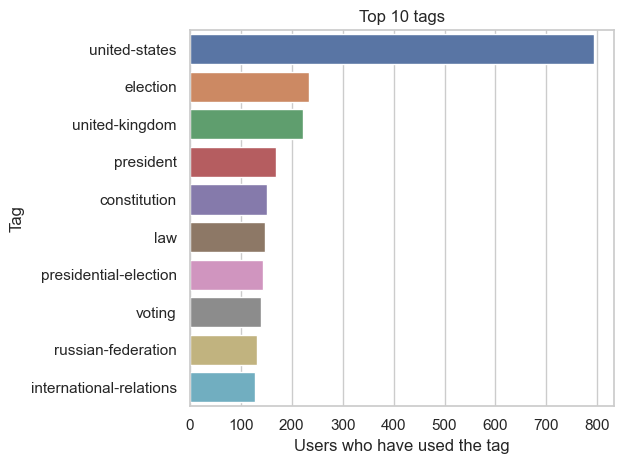

In [146]:
tags = tag_usercountry["TagList"].explode().value_counts().head(10)

# plot top 10 tags with seaborn
import seaborn as sns
sns.set_theme(style="whitegrid")
ax = sns.barplot(x=tags.values, y=tags.index)
ax.set(xlabel="Users who have used the tag", ylabel="Tag")
ax.set_title("Top 10 tags")
# expand the borders of the plot
ax.figure.tight_layout()
plt.savefig(DATA_DIR / "politics" / "top_tags.png", dpi=300)

C:\Users\jhr\AppData\Local\Temp\ipykernel_16760\2560426167.py:9: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  tag_usercountry_uks["proportion"] = tag_usercountry_uks.groupby("country")["count"].apply(lambda x: x / x.sum())


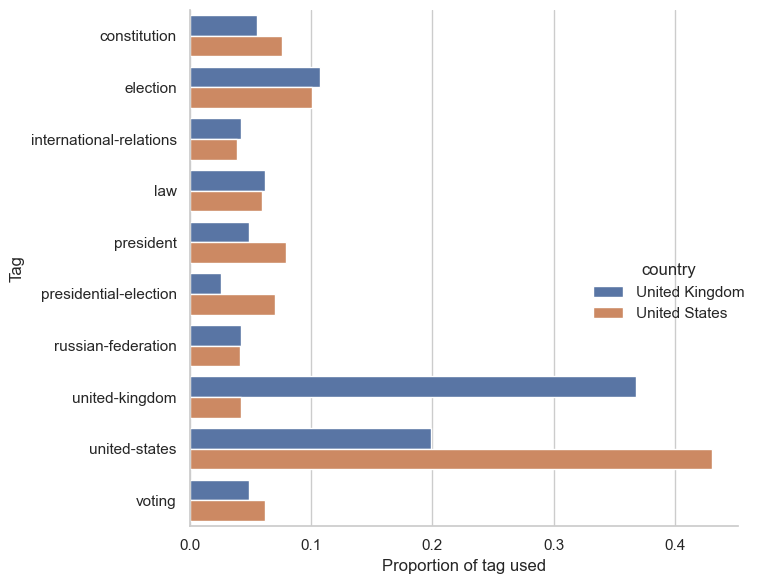

In [151]:
# facetted plot of top 10 tags by United States and United Kingdom
tag_usercountry_uks = tag_usercountry[tag_usercountry["country"].isin(["United States", "United Kingdom"])]

tag_usercountry_uks = tag_usercountry_uks.explode("TagList")
tag_usercountry_uks = tag_usercountry_uks[tag_usercountry_uks["TagList"].isin(tags.index)]
tag_usercountry_uks = tag_usercountry_uks.groupby(["country", "TagList"]).size().reset_index(name="count")

# get proportion per country
tag_usercountry_uks["proportion"] = tag_usercountry_uks.groupby("country")["count"].apply(lambda x: x / x.sum())
tag_usercountry_uks

ax = sns.catplot(x="proportion", y="TagList", hue="country", data=tag_usercountry_uks, kind="bar", height=6)
ax.set(xlabel="Proportion of tag used", ylabel="Tag")
ax.set_titles("Tag usage in UK vs US")
# expand the borders of the plot
ax.fig.tight_layout()
plt.savefig(DATA_DIR / "politics" / "top_tags_facetted.png", dpi=300)

In [142]:
len(tag_usercountry.index) == len(tag_usercountry.index.unique())

True

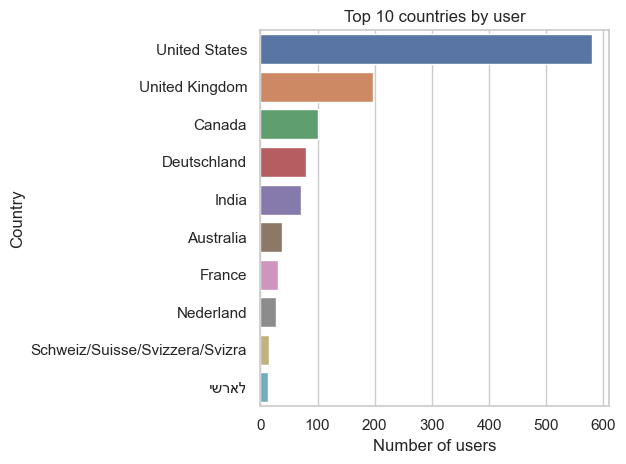

In [152]:
countries = tag_usercountry["country"].value_counts().head(10)

# plot top 10 countries with seaborn
sns.set_theme(style="whitegrid")
ax = sns.barplot(x=countries.values, y=countries.index)
ax.set(xlabel="Number of users", ylabel="Country")
ax.set_title("Top 10 countries by user")
# expand the borders of the plot
ax.figure.tight_layout()
plt.savefig(DATA_DIR / "politics" / "top_countries_users.png", dpi=300)

In [59]:
tagcountry_dict = tag_usercountry.to_dict(orient="index")


18.0


In [106]:
def check_numeric(x: str) -> bool:
    try:
        float(x)
        return True
    except ValueError:
        return False

In [114]:
from pyvis.network import Network

In [126]:
tag_users = tag_usercountry["TagList"].explode().reset_index().rename(columns={"OwnerUserId": "source", "TagList": "target"})

# create a graph from the edge-list
tagG = nx.from_pandas_edgelist(tag_users, "source", "target", create_using=nx.DiGraph)

# select highest degree users
user_degrees = {node: degree for node, degree in tagG.degree() if check_numeric(node)}
random_users = random.sample(list(user_degrees), 100)


node_colors = {node: ("blue" if check_numeric(node) else "red") for node in tagG.nodes}
nx.set_node_attributes(tagG, node_colors, "color")


# filter graph to only include neighbours of top users
subgraphs = [tagG.subgraph(nx.ego_graph(tagG, top_user, radius=1).nodes) for top_user in random_users]

# merge all subgraphs
full_graph = nx.compose_all(subgraphs)

# convert all nodes to string
full_graph = nx.relabel_nodes(full_graph, {node: str(node) for node in full_graph.nodes})

#full_graph.nodes


# visualize
nt = Network(height="500px", width="500x", bgcolor="#222222", font_color="white")
nt.from_nx(full_graph)
nt.save_graph("tag_graph.html")


In [131]:
tag_usercountry.to_pickle(DATA_DIR / "politics" / "tag_usercountry.pkl")

In [68]:

tag_similarity = dict.fromkeys(itertools.combinations(tagcountry_dict.keys(), 2), 0)
same_country = dict.fromkeys(itertools.combinations(tagcountry_dict.keys(), 2), 0)
for (key1, values1), (key2, values2) in itertools.combinations(tagcountry_dict.items(), 2):
    tag_similarity[(key1, key2)] = IoU(values1["TagList"], values2["TagList"])
    same_country[(key1, key2)] = values1["country"] == values2["country"]
    

In [74]:
tag_similaritydf = pd.DataFrame.from_dict(tag_similarity, orient="index", columns=["tag_similarity"])
same_countrydf = pd.DataFrame.from_dict(same_country, orient="index", columns=["same_country"])
full_df = pd.merge(tag_similaritydf, same_countrydf, left_index=True, right_index=True)
full_df.reset_index(inplace=True, names="user_pair")

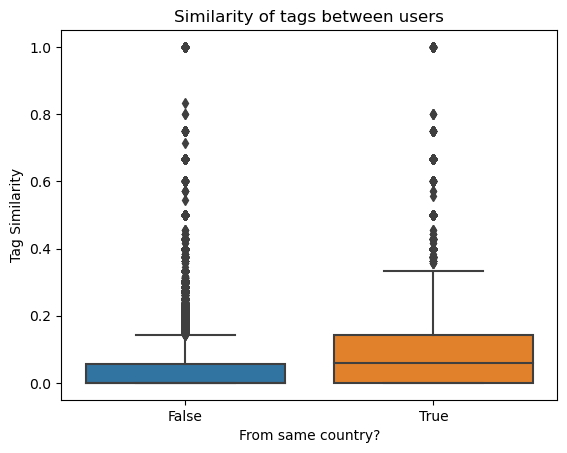

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns

# plot tag similarity facetted by same country as boxplot
fig, ax = plt.subplots()
sns.boxplot(data=full_df, x="same_country", y="tag_similarity", ax=ax)
ax.set_title("Similarity of tags between users")
ax.set_xlabel("From same country?")
ax.set_ylabel("Tag Similarity")
plt.savefig("tag_similarity.png", dpi=300)

In [89]:
true_df = full_df[full_df["same_country"]]
false_df = full_df[~full_df["same_country"]]
false_sample = false_df.sample(n=true_df.shape[0], random_state=42)

print(f"shape of true_df: {true_df.shape}\nshape of false_df: {false_sample.shape}")

shape of true_df: (200594, 3)
shape of false_df: (200594, 3)


In [90]:
# import t-test
import scipy.stats as stats

# calculate t-test
full_test = stats.wilcoxon(true_df["tag_similarity"], false_sample["tag_similarity"])


In [91]:
full_test

WilcoxonResult(statistic=2704126142.0, pvalue=0.0)

In [20]:

userdf = pd.read_csv(DATA_DIR / "politics" / "user_loc_data.csv")
userdf.set_index("Id", inplace=True)

In [21]:
userdf.index

Int64Index([   -1,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            44443, 44444, 44445, 44446, 44447, 44448, 44449, 44450, 44451,
            44452],
           dtype='int64', name='Id', length=36327)

In [94]:
full_df.to_csv(DATA_DIR / "politics" / "tag_similarity.csv")

In [23]:
same_country_dict = {}
for (key1, key2) in itertools.combinations(usertag_dict.keys(), 2):
    country1 = userdf.loc[int(key1), "country"]
    country2 = userdf.loc[int(key2), "country"]
    same_country_dict[(key1, key2)] = country1 == country2
    break


In [25]:
same_country_dict

{(18.0, 21.0): False}